&copy; 2024 by Pearson Education, Inc. All Rights Reserved. The content in this notebook is based on the book [**Python for Programmers**](https://amzn.to/2VvdnxE).

In [ ]:
%%html
<!-- CSS settings for this notbook -->
<style>
    h1 {color:#BB0000}
    h2 {color:purple}
    h3 {color:#0099ff}
    hr {    
        border: 0;
        height: 3px;
        background: #333;
        background-image: linear-gradient(to right, #ccc, black, #ccc);
    }
</style>

# 16. Big Data: Hadoop, Spark, NoSQL and IoT 

In [ ]:
# enable high-res images in notebook 
%config InlineBackend.figure_format = 'retina'

# 16.6 Spark
* Use **PySpark** and **Spark functional-style programming** to summarize **word frequencies** in **Romeo and Juliet**
* Use **PySpark** and **Spark Structured Streaming** to summarize streaming hashtags from Mastodon's federated live stream
* **Hadoop** break tasks into pieces that do **lots of disk I/O across many computers**
* **Spark** performs certain big-data tasks **in memory** for **better performance**

## 16.6.1 Spark Overview
* In big data, **performance is crucial**
* **Hadoop** is geared to **disk-based** batch processing
* Many **big-data** applications **demand better performance** 
    * E.g., **fast streaming** applications requiring **real-time** or **near-real-time processing**  
* Spark **in-memory** architecture “**has been used to sort 100 TB of data 3X faster than Hadoop MapReduce on 1/10th of the machines**”[\[2\]](https://spark.apache.org/faq.html) 
* Runs some workloads up to **100 times faster** than Hadoop [\[3\]](https://spark.apache.org/) 

<!-- 
### Architecture and Components (1 of 2)
* Spark uses **resilient distributed datasets (RDDs)** to process distributed data with **functional-style programming** 
* Hadoop uses **replication for fault tolerance** &mdash; adds **more disk-based overhead**
* **RDDs** eliminate disk-based overhead by 
    * **remaining in memory** &mdash; use disk only if data **can't fit in memory**
    * **not replicating data**
* **Fault tolerance** &mdash; Spark **remembers steps** used to **create an RDD**
    * If a **node fails**, Spark **rebuilds the RDD** [\[1\]](https://spark.apache.org/research.html) 
-->

<!-- 
### Architecture and Components (2 of 2)
* **Spark distributes operations** to a cluster’s nodes for **parallel execution**
* **Spark streaming** enables you to **process data as it’s received**
* **Spark `DataFrame`s** (similar to pandas `DataFrames`), enable you to **manipulate RDDs** as a **collection of named columns**
* Can use **Spark `DataFrame`s** with **Spark SQL** to **query distributed data**
* **Spark MLlib** (the **Spark Machine Learning Library**) enables you to perform **machine-learning algorithms** on distributed data
-->

### [**Databricks**](https://databricks.com)
* A **Spark-specific vendor**  
* Their website is an excellent resource for **learning Spark**
* **Paid version** runs on **Amazon AWS** or **Microsoft Azure**
* **Free Databricks Community Edition** is a great way to get started with both **Spark** and the **Databricks** environment
* [**Databricks free e-books**](https://databricks.com/resources/type/ebooks)

## 16.6.2 Docker and the Jupyter Docker Stacks
### Docker 
* Some software packages we use in this chapter require **complicated setup and configuration**
* **Preconfigured containers** can help you **get started** with new technologies **quickly and conveniently** 

### Jupyter Docker Stacks 
<!--docker pull jupyter/pyspark-notebook:lab-3.4.7-->
* Preconfigured [**Jupyter Docker stacks**](https://jupyter-docker-stacks.readthedocs.io/en/latest/index.html) 
* **`jupyter/pyspark-notebook`** is configured with **Spark and PySpark** 
* For details on installing and running **Docker** and the **`jupyter/pyspark-notebook`**, see 
    * [**Python Fundamentals LiveLessons videos**](https://learning.oreilly.com/videos/python-fundamentals/9780135917411/9780135917411-PFLL_Lesson16_34)
    * [**Python for Programmers** Section 16.6.2](https://learning.oreilly.com/library/view/Python+for+Programmers,+First+Edition/9780135231364/ch16.xhtml#ch16lev2sec25)

```
docker run -p 8888:8888 -p 4040:4040 -it --user root \
    -v fullPathTo/ch16:/home/jovyan/work \
    jupyter/pyspark-notebook start.sh jupyter lab
```
<!-- 04/24/2023 docker run -p 8895:8888 -p 4040:4040 -it --user root -v ~/Documents/PythonDataScienceFullThrottleNEW/ch16:/home/jovyan/work jupyter/pyspark-notebook start.sh jupyter lab -->

* **Install TextBlob and Tweepy into the container**
    * `docker ps`  
    **lists running containers**
    * `docker exec -it container_name /bin/bash`  
    **replace container_name with the name from `docker ps`**
    * `conda install textblob`
    * `pip install mastodon.py`
    
<!--
docker run -p 8896:8888 -p 4040:4040 -it --user root  -v /Users/pauldeitel/Documents/PythonDataScienceFullThrottle/ch16/:/home/jovyan/work jupyter/pyspark-notebook:14fdfbf9cfc1 start.sh jupyter lab
-->

## 16.6.3 Word Count with Spark
* Use Spark **filter, map and reduce** to implement a simple **word count** example that summarizes the words in **Romeo and Juliet**

### Loading the NLTK Stop Words

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

### Configuring a SparkContext 
* A **`SparkContext`** object gives you access to Spark’s capabilities
* Some Spark environments **create a `SparkContext` for you** but not the Jupyter Docker stack
* To create a **`SparkContext`**
    * Specify the **configuration options** with a **`SparkConf`** object 
    * **`setMaster`** specifies the **Spark cluster’s URL**
    * **`local[*]`** &mdash; Spark is executing on your **`local` computer** 
    * **`*`** &mdash; Use same number of **threads** as **cores** on your computer
        * Simulates **parallelism of Spark clusters**

In [ ]:
from pyspark import SparkConf
configuration = SparkConf().setAppName('RomeoAndJulietCounter')\
                           .setMaster('local[*]')

In [ ]:
from pyspark import SparkContext
sc = SparkContext(conf=configuration)

### Reading the Text File and Mapping It to Words
* You work with a **`SparkContext`** using **functional-style programming** applied to an **RDD**
* **RDD** enables you to **transform the data** stored throughout a **cluster** in **HDFS**
* Get a new **`RDD`** representing all words in **Romeo and Juliet**:

In [ ]:
from textblob.utils import strip_punc

In [ ]:
tokenized = sc.textFile('RomeoAndJuliet.txt')\
              .flatMap(lambda line: line.lower().split())\
              .map(lambda word: strip_punc(word, all=True))

### Removing the Stop Words
* Get a new **`RDD`** with **no stop words** remaining:

In [ ]:
filtered = tokenized.filter(lambda word: word not in stop_words)

### Counting Each Remaining Word 
* Now we can **count** the number of **occurrences** of each word
* First **`map`** each word to a **tuple** containing the **word** and **`1`**
* **`reduceByKey`** with the **`operator`** module’s **`add` function** as an argument **adds** the counts for tuples that contain same **key** (`word`)

In [ ]:
from operator import add
word_counts = filtered.map(lambda word: (word, 1)).reduceByKey(add)

### Keeping Only the Words with Counts Greater Than or Equal to 60

In [ ]:
filtered_counts = word_counts.filter(lambda item: item[1] >= 60)

### Sorting in Descending Order and Displaying the Results (1 of 2)
* At this point, we’ve specified all the steps to **count the words**
* When you call an **`RDD`'s `collect` method**, **Spark** 
    * initiates the **processing steps**
    * **returns a list** containing the final results &mdash; **word-count tuples**
* Everything **appears to execute on one computer**
* Spark **distributes tasks among the cluster’s worker nodes** 

In [ ]:
from operator import itemgetter
sorted_items = sorted(filtered_counts.collect(),
                      key=itemgetter(1), reverse=True)

### Sorting and Displaying the Results (2 of 2)
* We determine the **word with the most letters** so we can **right-align** the words

In [ ]:
max_len = max([len(word) for word, count in sorted_items])
for word, count in sorted_items:
    print(f'{word:>{max_len}}: {count}')

In [ ]:
# terminate current SparkContext so we can create another for next example
sc.stop()  

### Spark Monitoring Interface
* https://spark.apache.org/docs/latest/monitoring.html
* http://localhost:4040

## 16.6.4 Spark Word Count on Microsoft Azure
* For instructions on how to **run the preceding Spark example using Microsoft Azure HDInsight** see 
    * [**Python Fundamentals LiveLessons videos**](https://learning.oreilly.com/videos/python-fundamentals/9780135917411/9780135917411-PFLL_Lesson16_36) 
    * [**Python for Programmers, Section 16.6.4**](https://learning.oreilly.com/library/view/Python+for+Programmers,+First+Edition/9780135231364/ch16.xhtml#ch16lev2sec27)

<hr style="height:2px; border:none; color:#000; background-color:#000;">

# 16.7 Spark Structured Streaming: Counting Hashtags Using the `pyspark-notebook` Docker Stack
* Spark Streaming vs. Structured Streaming:  
https://dzone.com/articles/spark-streaming-vs-structured-streaming
* Spark: RDD vs DataFrames:  
https://blog.knoldus.com/spark-rdd-vs-dataframes/
* Structured Streaming Programming Guide:  
https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html

### Application Overview
* **Stream toots** and summarize **top-20 hashtags** in the live federated stream 
* Display in dynamically updating **bar chart** 
* **Spark Structured Streaming** will read toots and **summarize hashtags**
* Parts of this sample app communicate with one another via **network sockets**
    * low-level **client/server networking** in which a **client** app communicates with a **server** app over a **network** using techniques **similar to file I/O**
    * **socket** represents one **endpoint of a connection**
* We installed **Mastodon.py** into the `pyspark-notebook` Docker stack (described earlier in the notebook)

## 16.7.1 Streaming toots to a Socket
* The script **`starttootstream.py`** contains modified **`TootListener` class** from our Data Mining Mastodon presentation
* **Streams** the specified number of toots and **sends them to a socket on the local computer**
* Requires **`keys_mastodon.py`** containing **Mastodon credentials**

### Executing the Script in the Docker Container
* **File > New > Terminal** 
* `cd work`
* `ipython starttootstream.py number_of_toots`
>```
>ipython starttootstream.py 1000
>```
* Script displays `"Waiting for connection"` until Spark connects to begin streaming the toots

<hr style="height:2px; border:none; color:#000; background-color:#000;">

### Class TOOTListener (see `starttootstream.py`)
* **Method `on_update`** extracts hashtags, converts to lowercase and creates a space-separated string of hashtags to send to Spark 
* Uses `connection`’s **`send`** method to send string to whatever is reading from that socket 
    * **`send`** expects as its argument a **sequence of bytes**
    * **`hashtags_string.encode('utf-8')`** converts a string to bytes 
* Spark Structured Streaming automatically reconstructs the strings

### Main Application 
* Get the **number of toots to process** 
* Get **socket object** that we’ll use to wait for a connection from the Spark application
* **Bind the socket** to a hostname or IP address and a port number 
    * Script **listens** for an initial connection  
* **Wait until a connection is received** before starting the stream
* **`accept`** the connection
    * Returns a tuple containing a new **socket object** that the script will use to communicate with the Spark application and the **IP address** of the Spark application’s computer
* Start the Mastodon federatedfederated stream

## 16.7.2 Summarizing Toot Hashtags
* Use **Spark Structured Streaming** to read the hashtags sent via a socket by the script `starttootstream.py` and summarize the results.

### Importing the Libraries

In [1]:
from IPython.display import clear_output
from pyspark.sql.functions import explode, split
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

### Function to Display a Barplot of the Top-20 Hashtags So Far

In [2]:
def display_barplot(epoch_id, spark_df, x, y, scale=1.0, size=(8, 4.5)):
    """Displays a Spark DataFrame's contents as a bar plot."""
    df = spark_df.toPandas()
    
    # remove prior graph when new one is ready to display
    clear_output(wait=True) 

    if not df.empty: 
        print(f'EPOCH_ID: {epoch_id}')
        df = df.sort_values(by='count', ascending=False).head(20)
    else:
        print(f'EPOCH_ID: {epoch_id}. Empty DataFrame')
        return
    
    # create and configure a Figure containing a Seaborn barplot 
    plt.figure(figsize=size)
    sns.set(font_scale=scale)
    barplot = sns.barplot(data=df, x=x, y=y, 
                          palette=sns.color_palette('cool', 20))
    
    # rotate the x-axis labels 90 degrees for readability
    for item in barplot.get_xticklabels():
        item.set_rotation(90)
        
    plt.tight_layout()
    plt.show()

### Get Number of Cores Available to the App

In [3]:
cores = os.cpu_count()

In [4]:
cores

6

### Create a SparkSession to Track Hashtags
* Runs on local machine using all available cores

In [5]:
spark = SparkSession.builder \
    .appName('HashtagFrequency') \
    .master('local') \
    .config('spark.driver.cores', cores) \
    .config('spark.executor.cores', cores) \
    .getOrCreate()

### Create a DataFrame to Read Streaming Data
* Will read lines of space-separated hashtags from socket
* Following statement connects to the streaming app using a **socket** on **localhost** at port **9876**

In [6]:
lines = spark.readStream \
    .format('socket') \
    .option('host', 'localhost') \
    .option('port', 9876) \
    .load()

### Create New Spark DataFrame in Which Each Hashtag is a Separate Row 
* 1. `split()` call breaks line of text at each space
* 2. `explode()` call create new DataFrame row for each hashtag
* 3. `select()` call applies its argument to each line of text to build the new DataFrame
* 4. `alias()` call creates a table name for the DataFrame -- used in SQL queries across distributed data

In [7]:
hashtags = lines.select(explode(split(lines.value, ' ')).alias('hashtag'))

### Count Frequencies of the Hashtags
* Creates two-column result containing hashtags and counts

In [8]:
counts = hashtags.groupBy('hashtag').count()

### start the app and call display_barplot every 10 seconds
1. `writeStream` returns a DataStreamWriter used to configure the app's output
2. `outputMode()` call indicates all results will be output, not just new/updated ones
3. `forEachBatch()` call receives the DataFrame and a unique epoch ID for the current microbatch of data being processed
4. `trigger()` call sets amount of time between batches of data; can be in seconds, minutes, hours or a combo
5. `start()` launches the application

In [9]:
query = counts.writeStream \
    .outputMode('complete') \
    .foreachBatch(lambda df, epoch_id: display_barplot(epoch_id, df, x='hashtag', y='count')) \
    .trigger(processingTime='10 seconds') \
    .start()

### Wait for Streaming to Finish
* You'd execute this in a standalone app
* Can call `query.stop()` to terminate app 

In [10]:
import warnings

# disable glyph warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

EPOCH_ID: 13


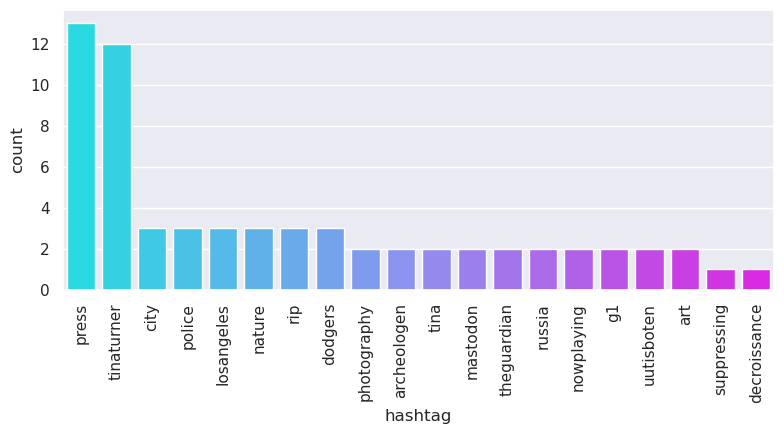

In [ ]:
query.awaitTermination(timeout=600) # terminate in 600 seconds

<hr style="height:2px; border:none; color:#000; background-color:#000;">

# More Info 
* See Lesson 16 in [**Python Fundamentals LiveLessons** here on O'Reilly Online Learning](https://learning.oreilly.com/videos/python-fundamentals/9780135917411)
* See Chapter 16 in [**Python for Programmers** on O'Reilly Online Learning](https://learning.oreilly.com/library/view/python-for-programmers/9780135231364/)
* See Chapter 17 in [**Intro Python for Computer Science and Data Science** on O'Reilly Online Learning](https://learning.oreilly.com/library/view/intro-to-python/9780135404799/)
* Interested in a print book? Check out:

| Python for Programmers<br>(640-page professional book) | Intro to Python for Computer<br>Science and Data Science<br>(880-page college textbook)
| :------ | :------
| <a href="https://amzn.to/2VvdnxE"><img alt="Python for Programmers cover" src="../images/PyFPCover.png" width="150" border="1"/></a> | <a href="https://amzn.to/2LiDCmt"><img alt="Intro to Python for Computer Science and Data Science: Learning to Program with AI, Big Data and the Cloud" src="../images/IntroToPythonCover.png" width="159" border="1"></a>

>Please **do not** purchase both books&mdash;_Python for Programmers_ is a subset of _Intro to Python for Computer Science and Data Science_

<hr style="height:2px; border:none; color:#000; background-color:#000;">

&copy; 1992-2024 by Pearson Education, Inc. All Rights Reserved. The content in this notebook is based on the book [**Python for Programmers**](https://amzn.to/2VvdnxE).